### Environment setup

In [ ]:
!pip install pynwb
!pip install matplotlib

In [2]:
from pynwb import NWBHDF5IO
import numpy as np
import matplotlib.pyplot as plt

### Read NWB files

In [3]:
lfp_filepath = "../../../data/probeA_lfp.nwb"
stim_filepath = "../../../data/spike_times.nwb"

In [4]:
lfp_io = NWBHDF5IO(lfp_filepath, mode="r", load_namespaces=True)
lfp_file = lfp_io.read()
stim_io = NWBHDF5IO(stim_filepath, mode="r", load_namespaces=True)
stim_file = stim_io.read() 

C:\Users\carter.peene\AppData\Local\Programs\Python\Python39\lib\site-packages\hdmf\spec\namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.5.0 because version 1.5.1 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
C:\Users\carter.peene\AppData\Local\Programs\Python\Python39\lib\site-packages\hdmf\spec\namespace.py:531: UserWarning: Ignoring cached namespace 'core' version 2.4.0 because version 2.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
C:\Users\carter.peene\AppData\Local\Programs\Python\Python39\lib\site-packages\hdmf\spec\namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.1.0 because version 0.2.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


In [5]:
lfp_data = lfp_file.acquisition["probe_0_lfp_data"]
series = lfp_data.data

In [6]:
stimulus_names = list(stim_file.intervals.keys())
print(stimulus_names)

['ICkcfg0_presentations', 'ICkcfg1_presentations', 'ICwcfg0_presentations', 'ICwcfg1_presentations', 'RFCI_presentations', 'invalid_times', 'sizeCI_presentations', 'spontaneous_presentations']


In [7]:
stim_file.intervals["ICwcfg1_presentations"][0]

,start_time,stop_time,stimulus_name,stimulus_block,frame,stimulus_index,tags,timeseries
id,,,,,,,,
0,99.256575,99.656919,ICwcfg1,0.0,0.0,0.0,[stimulus_time_interval],"[(1, 1, timestamps pynwb.base.TimeSeries at 0x..."


### Visualizing stimuli

1. align stimulus and lfp
2. identify events within lfp
3. get window of lfp around event
4. split lfp eventwise into 3d array
5. calculate average across events
6. calculate average across nodes and events

In [8]:
stimulus_name = ""
interval_start = -1.0
interval_end = 5.0
node = 0

In [47]:
rate = 1000 / (lfp_data.timestamps[2000] - lfp_data.timestamps[1000])
print(rate)

1250.001346958406


In [50]:
lfp_data.data
lfp_data.timestamps[0]

4.787164854572537

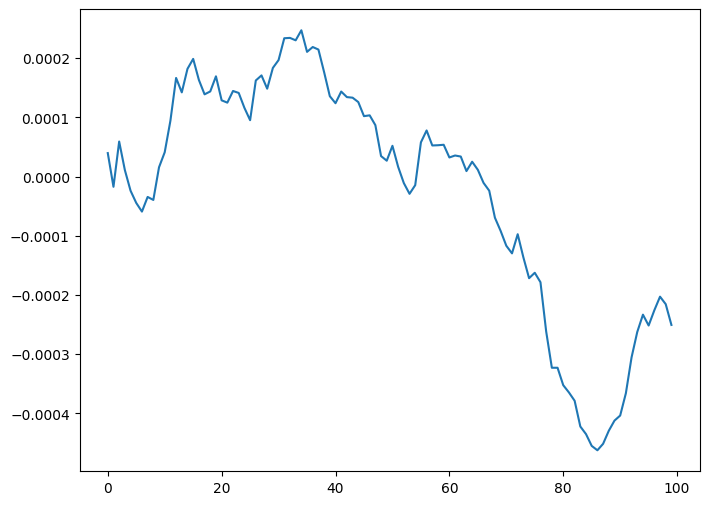

In [41]:
# nodewise view
%matplotlib inline
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(lfp_data.data[0:100,node])
plt.show()